In [1]:
import xarray as xr
import warnings
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.stats import ttest_ind
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import os
from glob import glob
from scipy.stats.stats import pearsonr
from statsmodels.distributions.empirical_distribution import ECDF

os.chdir('/Volumes/Seagate_ZQ2/SWE_datasets/rawData')

# ignore MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_96269/3617951439.py:16: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [2]:
def _compute_slope(var):
    if np.isnan(var).all():
        slp = np.nan
    else:
        var = var[~np.isnan(var)]
        slp = linregress(range(len(var)),var).slope
    return slp

def _compute_trend_pval(var):
    if np.isnan(var).all():
        pval = np.nan
    else:
        var = var[~np.isnan(var)]
        pval = linregress(range(len(var)),var).pvalue
    return pval
    
def trend_cal(data):
    slopes = xr.apply_ufunc(_compute_slope,
                            data,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['year']],
                            output_dtypes=[float],
                            )
    return slopes

def trend_cal_pval(data):
    pvals = xr.apply_ufunc(_compute_trend_pval,
                            data,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['year']],
                            output_dtypes=[float],
                            )
    return pvals

def add_panel_label(ax, label, x = 0, y = 1.1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

In [3]:
hist_source = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CNRM-CM6-1', 'CanESM5', 'CanESM5-1', 'E3SM-1-0', 'E3SM-2-0',
'EC-Earth3','EC-Earth3-AerChem','EC-Earth3-CC','EC-Earth3-Veg','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','GISS-E2-1-H','GISS-E2-2-G','HadGEM3-GC31-LL','IPSL-CM5A2-INCA',
'IPSL-CM6A-LR','KIOST-ESM','MIROC6','MPI-ESM-1-2-HAM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorESM2-LM','NorESM2-MM','TaiESM1']
NAT_source = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'E3SM-2-0',
'GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL', 'IPSL-CM6A-LR','MIROC6', 'MRI-ESM2-0','NorESM2-LM']

paths = {
    'hist':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/HIST/',
    'NAT':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/NAT/'
}

hist_source_paths = {hist_source[i]:glob(paths['hist'] + 'snw_TP_' + hist_source[i] + '*.nc')[0] for i in range(len(hist_source))}
NAT_source_paths = {NAT_source[i]:glob(paths['NAT'] + 'snw_TP_' + NAT_source[i] + '*.nc')[0] for i in range(len(NAT_source))}

# read NINO3 index
tos_nino3_index_HIST = pd.read_csv('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/HIST/tos_Nino3_index_1950-2025.csv',index_col=0)
tos_nino3_index_NAT = pd.read_csv('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/NAT/tos_Nino3_index_1950-2020.csv',index_col=0)

# read shapefile for TP
TP_shp = gpd.read_file('/Users/zeqinhuang/Documents/dataset/Maps/Tibetan_Plateau/Tibetan_Plateau2.shp')

# utility functions

## calculate SWEI

In [4]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm, gamma

def droughtindx(nsample):
    indx = []
    for i in range(nsample):
        px = (i+1-0.44)/(nsample+0.12)
        indx.append(norm.ppf(px))
    return indx

# get ranalysis SWE dataarray of each monthly dataset
def get_CMIP6_swe_data(sn, senario='hist'):
    if senario == 'hist':
        data = xr.open_dataset(hist_source_paths[sn])
    elif senario == 'NAT':
        data = xr.open_dataset(NAT_source_paths[sn])
    else:
        print('Please input the correct senario name: hist or NAT')
    
    # clip the data with Tibetan Plateau shapefile using rioxarray
    data_da = data['snw']
    data_da.rio.set_crs("epsg:4326")
    data_da.rio.set_spatial_dims("lon", "lat", inplace=True)
    data_da = data_da.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)

    data = data_da.to_dataset()
    return data

def get_reshape_swei(sn, senario='hist'):
    ds = get_CMIP6_swe_data(sn, senario)
    swe = ds['snw']
    nlat = swe.shape[2]
    nlon = swe.shape[1]
    nm = 12
    # Compute the 3-month cumulative sum for each pixel
    ds_cumsum = ds.rolling(time=3, min_periods=3).sum()
    # select time span from 1979-09 to 2023-08 (Water year)
    if senario == 'hist':
        ds_cumsum = ds_cumsum.sel(time=slice('1979-09', '2023-08'))
    elif senario == 'NAT':
        try:
            year_range = pd.DatetimeIndex(ds['time']).year.unique()
        except:
            year_range = ds.indexes['time'].to_datetimeindex().year.unique()
        ds_cumsum = ds_cumsum.sel(time=slice(str(year_range[-45])+'-09', str(year_range[-1])+'-08'))
    years = np.unique(ds_cumsum.time.dt.year)
    # Reshape the data back into a 4D array of (year, month, lat, lon)
    ds_new = xr.DataArray(
        ds_cumsum.snw.data.reshape((-1, 12, ds.sizes['lat'], ds.sizes['lon'])),
        dims=('year', 'month', 'lat', 'lon'),
        coords={'year': years[:-1], 'month': [9,10,11,12,1,2,3,4,5,6,7,8], 'lat': ds['lat'], 'lon': ds['lon']}
    )
    return ds_new


# SWEI calculation for historical (CMIP6)
def get_CMIP6_swei(sn, senario='hist'):
    ds = get_CMIP6_swe_data(sn, senario)
    swe = ds['snw']

    nlat = swe.shape[2]
    nlon = swe.shape[1]
    nm = 12
    # Compute the 3-month cumulative sum for each pixel
    ds_cumsum = ds.rolling(time=3, min_periods=3).sum()
    # select time span from 1979-09 to 2023-08 (Water year)
    if senario == 'hist':
        ds_cumsum = ds_cumsum.sel(time=slice('1979-09', '2023-08'))
    elif senario == 'NAT':
        try:
            year_range = pd.DatetimeIndex(ds['time']).year.unique()
        except:
            year_range = ds.indexes['time'].to_datetimeindex().year.unique()
        ds_cumsum = ds_cumsum.sel(time=slice(str(year_range[-45])+'-09', str(year_range[-1])+'-08'))
    years = np.unique(ds_cumsum.time.dt.year)
    months = np.unique(ds_cumsum.time.dt.month)
    # Reshape the data back into a 4D array of (year, month, lat, lon)
    ds_new = xr.DataArray(
        ds_cumsum.snw.data.reshape((-1, 12, ds.sizes['lat'], ds.sizes['lon'])),
        dims=('year', 'month', 'lat', 'lon'),
        coords={'year': years[:-1], 'month': [9,10,11,12,1,2,3,4,5,6,7,8], 'lat': ds['lat'], 'lon': ds['lon']}
    )
    
    nyr = len(years) - 1
    categ = np.zeros((nyr, nm, nlon, nlat))
    nsample = nyr
    sweix = droughtindx(nsample)  # all values for each pixel.
    sweix = np.array(sweix)

    aindx = np.argsort(ds_new.data, axis=0)

    # Create a broadcasting version of sweix
    sweix_broadcasted = sweix[:, np.newaxis, np.newaxis, np.newaxis]

    # Assign sorted sweix values to categ based on sorted indices (array, indices, values, axis)
    np.put_along_axis(categ, aindx,sweix_broadcasted, axis=0)

    # clip category with Tibetan Plateau shapefile using rioxarray
    categ_da = xr.DataArray(categ, dims=('year', 'month', 'lat', 'lon'), coords={'year': years[:-1], 'month': [9,10,11,12,1,2,3,4,5,6,7,8], 'lat': ds['lat'], 'lon': ds['lon']})
    categ_da.rio.set_crs("epsg:4326")
    categ_da.rio.set_spatial_dims("lon", "lat", inplace=True)
    categ_da = categ_da.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)

    # Create the new xarray Dataset
    ds_swei = xr.Dataset(
        {'swei':(('year','month','lat','lon'), categ_da.data)},
        coords={'year': years[:-1], 'month': [9,10,11,12,1,2,3,4,5,6,7,8], 'lat': categ_da['lat'], 'lon': categ_da['lon']}
    )
    return ds_swei
            
# calculate area weighted SWEI
def cal_CMIP6_area_weighted_SWEI(sn, senario):
    if senario == 'hist':
        ds_swei = get_CMIP6_swei(sn, senario)
        ds_swei = ds_swei['swei']
    elif senario == 'NAT':
        ds_swei = NAT_swei_cal_2(sn)
    ds_swei_year = ds_swei.sel(month=3)
    # reshape from 4D to 3D
    ds_swei_month = ds_swei.stack(z=('year','month'))

    # calculate area-weighted mean of ds_swei
    weights = np.cos(np.deg2rad(ds_swei.lat))
    weights.name = 'weights'
    ds_swei_year_weighted = ds_swei_year.weighted(weights)
    ds_swei_month_weighted = ds_swei_month.weighted(weights)
    ds_swei_year_ts = ds_swei_year_weighted.mean(('lon','lat'))
    ds_swei_month_ts = ds_swei_month_weighted.mean(('lon','lat'))

    # assign time index to ds_swei_month_ts
    ds_swei_year_ts = ds_swei_year_ts
    ds_swei_month_ts = ds_swei_month_ts
    ds_swei_month_ts['z'] = pd.date_range(start='1979-09', end='2023-08', freq='MS')
    return ds_swei_year_ts, ds_swei_month_ts

In [5]:
# function to calculate the SWEI for historical
def _compute_hist_swei_grid(var_hist):
    ecdf = ECDF(var_hist, side='right')
    sweix = droughtindx(len(var_hist))
    sweix = np.array(sweix)
    aindx = np.argsort(var_hist)
    swei_hist = np.zeros(len(var_hist))
    np.put_along_axis(swei_hist, aindx, sweix, axis=0)
    return swei_hist

def hist_swei_cal(data_hist): ### a little bit too slow than "get_CMIP6_swei()"
    swei_hist = xr.apply_ufunc(_compute_hist_swei_grid,
                            data_hist,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['year']],
                            output_core_dims=[['year']],
                            output_dtypes=[float],
                            )
    # clip category with Tibetan Plateau shapefile using rioxarray
    swei_hist.rio.set_crs("epsg:4326")
    swei_hist.rio.set_spatial_dims("lon", "lat", inplace=True)
    swei_hist = swei_hist.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)
    swei_hist = swei_hist.transpose('year','month','lat','lon')
    return swei_hist

In [6]:
# function to calculate the SWEI of NAT
def _compute_NAT_swei_grid(var_hist,var_NAT):
    ecdf = ECDF(var_hist, side='right')
    NAT_rank = ecdf(var_NAT) * len(var_hist)
    NAT_rank = np.where(NAT_rank==0, 1, NAT_rank)
    NAT_rank = np.where(NAT_rank==len(var_hist), len(var_hist)-1, NAT_rank)

    sweix = droughtindx(len(var_hist))
    sweix = np.array(sweix)
    aindx = np.argsort(var_hist)
    swei_hist = np.zeros(len(var_hist))
    np.put_along_axis(swei_hist, aindx, sweix, axis=0)

    swei_NAT = np.zeros(len(var_NAT))
    for i in range(len(var_NAT)):
        swei_NAT[i] = sweix[int(NAT_rank[i])]
    return swei_NAT

def NAT_swei_cal(data_hist,data_NAT):
    swei_NAT = xr.apply_ufunc(_compute_NAT_swei_grid,
                            data_hist,
                            data_NAT,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['year'],['year']],
                            output_core_dims=[['year']],
                            output_dtypes=[float],
                            )
    # clip category with Tibetan Plateau shapefile using rioxarray
    swei_NAT.rio.set_crs("epsg:4326")
    swei_NAT.rio.set_spatial_dims("lon", "lat", inplace=True)
    swei_NAT = swei_NAT.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)
    swei_NAT = swei_NAT.transpose('year','month','lat','lon')
    return swei_NAT

def NAT_swei_cal_2(sn):
    data_hist = get_reshape_swei(sn, 'hist')
    data_NAT = get_reshape_swei(sn, 'NAT')
    data_NAT['year'] = data_hist.year  # keep equal along these coordinates (dimensions): 'year'
    swei_NAT = NAT_swei_cal(data_hist,data_NAT)

    ds = get_CMIP6_swe_data(sn, 'NAT')
    try:
        year_range = pd.DatetimeIndex(ds['time']).year.unique()
    except:
        year_range = ds.indexes['time'].to_datetimeindex().year.unique()
        
    swei_NAT['year'] = year_range[-45:-1]
    return swei_NAT
    

## correlation and p-value between SWEI and NINO3

In [7]:
# calculate the correlation between SWE and NINO34
# first define a function to calculate the correlation between two datasets
def corr_cal(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    corr = np.corrcoef(data1, data2)[0, 1]
    return corr
# define a function to calculate the p-value of the correlation between two datasets
def corr_p_cal(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    try:
        p = pearsonr(data1, data2)[1]
    except:
        p = np.nan
    return p

# calculate the correlation between SWEI and NINO3
def corr_SWEI_NINO3(sn, senario):
    if senario == 'hist':
        ds_swei = get_CMIP6_swei(sn, senario)
    elif senario == 'NAT':
        ds_swei = NAT_swei_cal_2(sn)
    ds_swei_year = ds_swei.sel(month=3)
    if senario == 'hist':
        ds_swei_year = ds_swei_year['swei']
    elif senario == 'NAT':
        pass

    # transform NINO3 to xarray dataarray
    if senario == 'hist':
        NINO3 = tos_nino3_index_HIST[sn]
    elif senario == 'NAT':
        NINO3 = tos_nino3_index_NAT[sn]
    else:
        print('Please input the correct senario name: hist or NAT')
        
    NINO3.index = pd.to_datetime(NINO3.index)
    NINO3_da = xr.DataArray(NINO3, dims=['time'])
    if senario == 'hist':
        NINO3_da = NINO3_da.sel(time=slice('1979', '2022'))
    elif senario == 'NAT':
        NINO3_da = NINO3_da.sel(time=slice(str(ds_swei_year['year'].values[0]), str(ds_swei_year['year'].values[-1])))
    else:
        pass
    NINO3_da_QS = NINO3_da.resample(time='QS-DEC').mean()
    NINO3_da_DJF = NINO3_da_QS.sel(time=NINO3_da_QS['time.month']==12)
    NINO3_da_DJF = NINO3_da_DJF[1:]

    # calculate the correlation between SWEI_march and NINO3_DJF
    SWEI_march_NINO3_corr = xr.apply_ufunc(corr_cal, ds_swei_year, NINO3_da_DJF, input_core_dims=[['year'], ['time']], vectorize=True)
    # mask SWEI_march_NINO3_corr with Tibetan Plateau shapefile using rioxarray
    SWEI_march_NINO3_corr.rio.set_crs("epsg:4326")
    SWEI_march_NINO3_corr.rio.set_spatial_dims("lon", "lat", inplace=True)
    SWEI_march_NINO3_corr_masked = SWEI_march_NINO3_corr.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)
    return SWEI_march_NINO3_corr_masked

# calculate pvalue of the correlation between SWEI and NINO3
def pvalue_corr_SWEI_NINO3(sn, senario='hist'):
    if senario == 'hist':
        ds_swei = get_CMIP6_swei(sn, senario)
    elif senario == 'NAT':
        ds_swei = NAT_swei_cal_2(sn)
    ds_swei_year = ds_swei.sel(month=3)

    if senario == 'hist':
        ds_swei_year = ds_swei_year['swei']
    elif senario == 'NAT':
        pass

    # transform NINO3 to xarray dataarray
    if senario == 'hist':
        NINO3 = tos_nino3_index_HIST[sn]
    elif senario == 'NAT':
        NINO3 = tos_nino3_index_NAT[sn]
    else:
        print('Please input the correct senario name: hist or NAT')
        
    NINO3.index = pd.to_datetime(NINO3.index)
    NINO3_da = xr.DataArray(NINO3, dims=['time'])
    if senario == 'hist':
        NINO3_da = NINO3_da.sel(time=slice('1979', '2022'))
    elif senario == 'NAT':
        NINO3_da = NINO3_da.sel(time=slice(str(ds_swei_year['year'].values[0]), str(ds_swei_year['year'].values[-1])))
    else:
        pass
    NINO3_da_QS = NINO3_da.resample(time='QS-DEC').mean()
    NINO3_da_DJF = NINO3_da_QS.sel(time=NINO3_da_QS['time.month']==12)
    NINO3_da_DJF = NINO3_da_DJF[1:]

    # calculate the pvalue of the correlation between SWEI_march and NINO3_DJF
    SWEI_march_NINO3_corr_p = xr.apply_ufunc(corr_p_cal, ds_swei_year, NINO3_da_DJF, input_core_dims=[['year'], ['time']], vectorize=True)
    # mask SWEI_march_NINO3_corr_p with Tibetan Plateau shapefile using rioxarray
    SWEI_march_NINO3_corr_p.rio.set_crs("epsg:4326")
    SWEI_march_NINO3_corr_p.rio.set_spatial_dims("lon", "lat", inplace=True)
    SWEI_march_NINO3_corr_p_masked = SWEI_march_NINO3_corr_p.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)
    return SWEI_march_NINO3_corr_p_masked

# plot the correlation between SWEI and NINO3
def plot_corr_SWEI_NINO3(sn,senario='hist',ax=None):
    SWEI_march_NINO3_corr_masked = corr_SWEI_NINO3(sn, senario=senario)
    SWEI_march_NINO3_corr_p_masked = pvalue_corr_SWEI_NINO3(sn, senario=senario)
    # plot SWEI_march_NINO3_corr_masked with matplotlib
    if ax == None:
        fig = plt.figure(figsize=(12, 5))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        ax.set_extent([70, 105, 25, 40], crs=ccrs.PlateCarree())
        SWEI_march_NINO3_corr_masked.plot(ax=ax, vmax=0.6, vmin=-0.6, cmap='RdBu_r', add_colorbar=True)
        # add hatches to the grid cells with p-value < 0.05
        SWEI_march_NINO3_corr_p_masked.where(SWEI_march_NINO3_corr_p_masked<0.05).plot.contourf(ax=ax, levels=[0, 0.05], hatches=['///'], alpha=0, add_colorbar=False)
        # ax.set_title('Correlation between winter (DJF) NIÑO3.4 index and annual maximum SWEI')
        ax.set_title(sn)
    else:
        SWEI_march_NINO3_corr_masked.plot(ax=ax, vmax=0.6, vmin=-0.6, cmap='RdBu_r', add_colorbar=False)
        # add hatches to the grid cells with p-value < 0.05
        SWEI_march_NINO3_corr_p_masked.where(SWEI_march_NINO3_corr_p_masked<0.05).plot.contourf(ax=ax, levels=[0, 0.05], hatches=['/////'], alpha=0, add_colorbar=False)
        # ax.set_title('Correlation between winter (DJF) NIÑO3.4 index and annual maximum SWEI')
        ax.set_title(sn)

# plot the spatial distribution of correlation between SWEI and NINO3

In [8]:
# plot the correlation between SWEI and NINO3
# plot a 8*4 subplot figure
number_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
                 'p','q','r','s','t','u','v','w','x','y','z','aa','bb','cc','dd','ee','ff']
def plot_corr_SWEI_NINO3_all(senario):
    if senario == 'hist':
        fig = plt.figure(figsize=(11, 16))
        for i in range(32):
            ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree())
            plot_corr_SWEI_NINO3(hist_source[i],senario=senario,ax=ax)
            ax.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
            add_panel_label(ax, number_labels[i], x=0.015, y=1.25)
            # add TP shapefile
            TP_shp.plot(ax=ax, edgecolor='black', facecolor='none')
            # add colorbar in the bottom
            if i == 31:
                fig.subplots_adjust(bottom=0.2)
                cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.0125])
                fig.colorbar(ax.collections[0], cax=cbar_ax, orientation='horizontal', extend='both')
                cbar_ax.set_title('Correlation coefficient between SWEI and NIÑO3 index',fontdict={'fontsize': 12})
    elif senario == 'NAT':
        fig = plt.figure(figsize=(8, 10))
        for i in range(15):
            ax = fig.add_subplot(5, 3, i+1, projection=ccrs.PlateCarree())
            plot_corr_SWEI_NINO3(NAT_source[i],senario=senario,ax=ax)
            # print(i)
            ax.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
            add_panel_label(ax, number_labels[i], x=0.015, y=1.25)
            # add TP shapefile
            TP_shp.plot(ax=ax, edgecolor='black', facecolor='none')
            # add colorbar in the bottom
            if i == 14:
                fig.subplots_adjust(bottom=0.2)
                cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.0125])
                fig.colorbar(ax.collections[0], cax=cbar_ax, orientation='horizontal', extend='both')
                cbar_ax.set_title('Correlation coefficient between SWEI and NIÑO3 index',fontdict={'fontsize': 12})
    else:
        print('Please input the correct senario name: hist or NAT')
    
    plt.subplots_adjust(wspace=0.05, hspace=0.3)


In [ ]:
# save correlation between SWEI and NINO3 under historical senario to netcdf
for sn in hist_source:
    SWEI_march_NINO3_corr_masked = corr_SWEI_NINO3(sn, senario='hist')
    SWEI_march_NINO3_corr_masked.name = 'SWEI_NINO3_corr'
    SWEI_march_NINO3_corr_p_masked = pvalue_corr_SWEI_NINO3(sn, senario='hist')
    SWEI_march_NINO3_corr_p_masked.name = 'SWEI_NINO3_corr_p'
    SWEI_march_NINO3_corr_masked.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/SWEI_NINO3_corr_' + sn + '.nc')
    SWEI_march_NINO3_corr_p_masked.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/SWEI_NINO3_corr_p_' + sn + '.nc')

In [ ]:
# save correlation between SWEI and NINO3 under NAT senario to netcdf
for sn in NAT_source:
    SWEI_march_NINO3_corr_masked = corr_SWEI_NINO3(sn, senario='NAT')
    SWEI_march_NINO3_corr_masked.name = 'SWEI_NINO3_corr'
    SWEI_march_NINO3_corr_p_masked = pvalue_corr_SWEI_NINO3(sn, senario='NAT')
    SWEI_march_NINO3_corr_p_masked.name = 'SWEI_NINO3_corr_p'
    SWEI_march_NINO3_corr_masked.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/SWEI_NINO3_corr_' + sn + '.nc')
    SWEI_march_NINO3_corr_p_masked.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/SWEI_NINO3_corr_p_' + sn + '.nc')

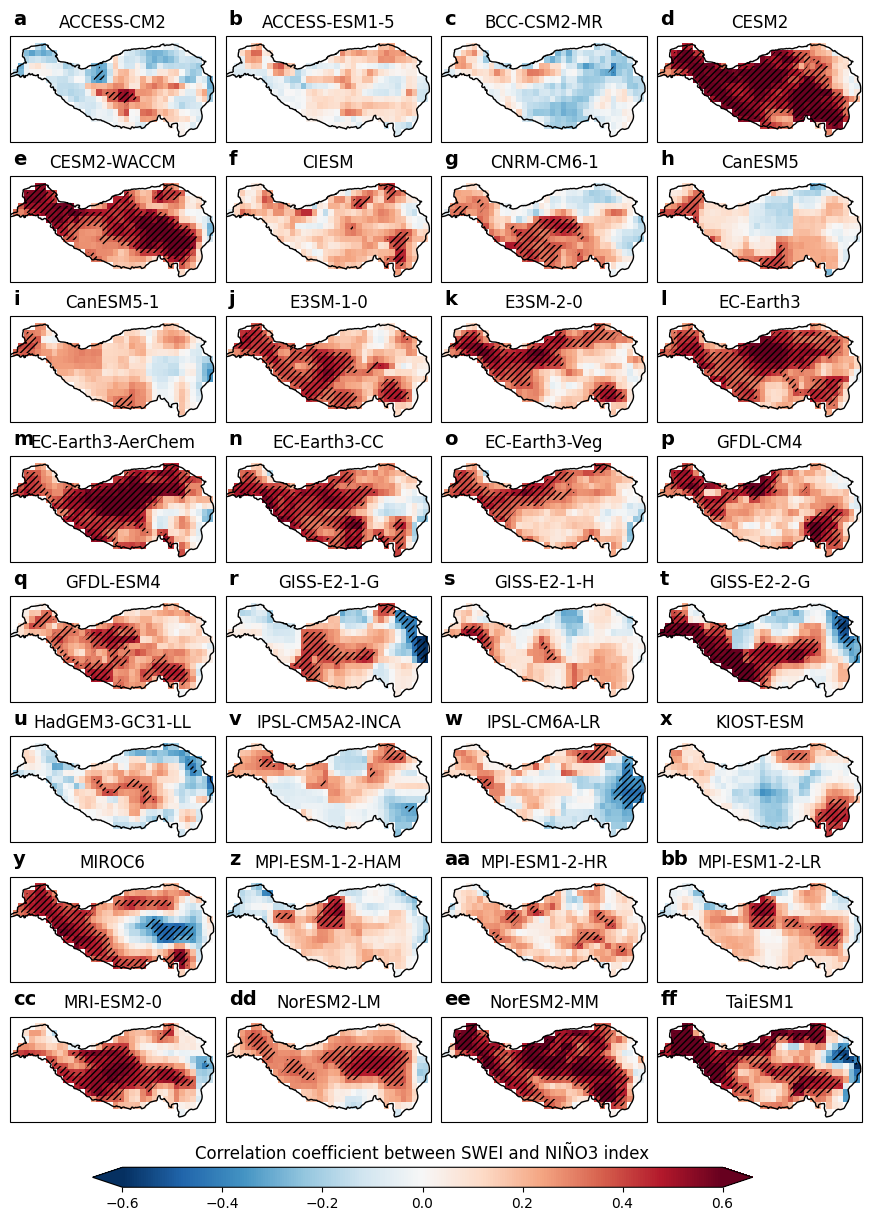

In [ ]:
plot_corr_SWEI_NINO3_all('hist')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/corr_SWEI_NINO3.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/corr_SWEI_NINO3.pdf', bbox_inches='tight')

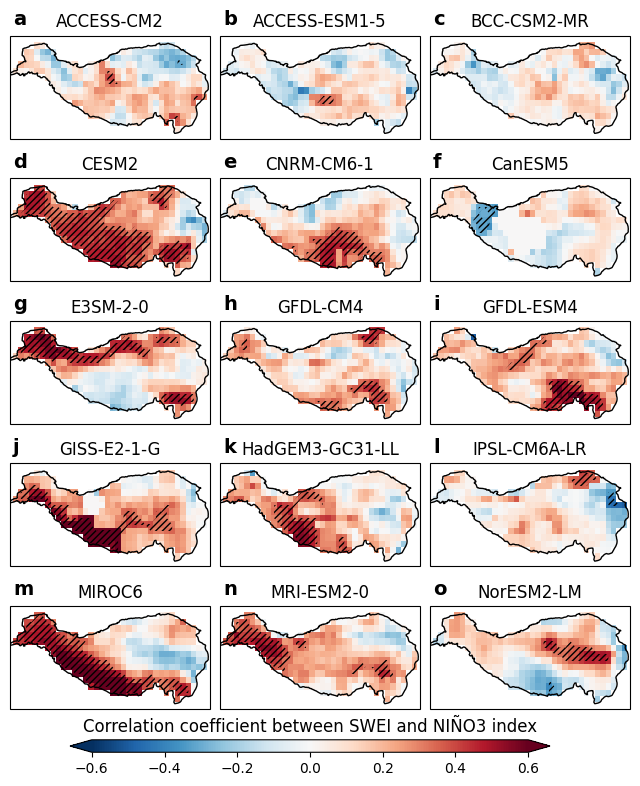

In [ ]:
plot_corr_SWEI_NINO3_all('NAT')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/corr_SWEI_NINO3_NAT.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/corr_SWEI_NINO3_NAT.pdf', bbox_inches='tight')

In [9]:
# plot ensemble mean of the correlation between SWEI and NINO3
def cal_SWEI_NINO3_corr_ensmean(senario):
    if senario == 'hist':
        sn_list = hist_source
    elif senario == 'NAT':
        sn_list = NAT_source
    else:
        print('Please input the correct senario name: hist or NAT')
    
    SWEI_NINO3_corr_ensmean = 0
    SWEI_NINO3_corr_pos_enssum = 0
    SWEI_NINO3_corr_neg_enssum = 0

    for sn in sn_list:
        SWEI_NINO3_corr = corr_SWEI_NINO3(sn, senario)
        try:
            SWEI_NINO3_corr = SWEI_NINO3_corr['SWEI_NINO3_corr']
        except:
            pass
        SWEI_NINO3_corr_pos = SWEI_NINO3_corr > 0
        SWEI_NINO3_corr_neg = SWEI_NINO3_corr < 0
        if sn == sn_list[0]:
            SWEI_NINO3_corr_ensmean = SWEI_NINO3_corr
            SWEI_NINO3_corr_pos_enssum = SWEI_NINO3_corr_pos * 1
            SWEI_NINO3_corr_neg_enssum = SWEI_NINO3_corr_neg * 1
        else:
            SWEI_NINO3_corr_ensmean = SWEI_NINO3_corr_ensmean + SWEI_NINO3_corr
            SWEI_NINO3_corr_pos_enssum = SWEI_NINO3_corr_pos_enssum + SWEI_NINO3_corr_pos * 1
            SWEI_NINO3_corr_neg_enssum = SWEI_NINO3_corr_neg_enssum + SWEI_NINO3_corr_neg * 1

    SWEI_NINO3_corr_ensmean = SWEI_NINO3_corr_ensmean/len(sn_list)
    SWEI_NINO3_corr_sig = ((SWEI_NINO3_corr_neg_enssum > len(sn_list) * 2 / 3) & (SWEI_NINO3_corr_ensmean < 0)) | ((SWEI_NINO3_corr_pos_enssum > len(sn_list) * 2 / 3) & (SWEI_NINO3_corr_ensmean > 0))
    return SWEI_NINO3_corr_ensmean, SWEI_NINO3_corr_sig

<GeoAxes: title={'center': 'Correlation between SWEI and NIÑO3'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

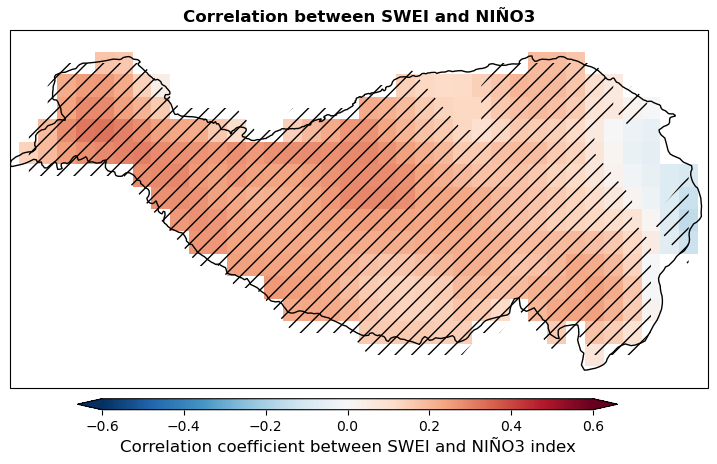

In [10]:
# plot ensemble mean of the correlation between SWEI and NINO3 for historical senario
swei_NINO3_corr_ensmean_hist, swei_NINO3_corr_sig_hist = cal_SWEI_NINO3_corr_ensmean('hist')
fig = plt.figure(figsize=(9, 5.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.2, 0.13, 0.6, 0.02])
p = swei_NINO3_corr_ensmean_hist.plot(ax=ax, vmax=0.6, vmin=-0.6, cmap='RdBu_r', add_colorbar=False)
fig_cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal', extend='both')
fig_cbar.set_label('Correlation coefficient between SWEI and NIÑO3 index',fontdict={'fontsize': 12})
swei_NINO3_corr_sig_hist.plot.contourf(ax=ax, hatches=[None,'//'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax.set_title('Correlation between SWEI and NIÑO3',fontdict={'fontsize': 12, 'fontweight': 'bold'})
# add TP shapefile
TP_shp.plot(ax=ax, edgecolor='black', facecolor='none')

<GeoAxes: title={'center': 'Correlation between SWEI and NIÑO3'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

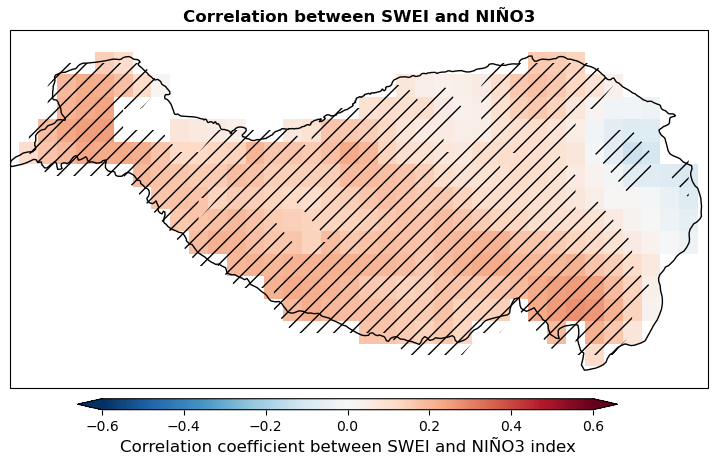

In [11]:
# plot ensemble mean of the correlation between SWEI and NINO3 for NAT senario
swei_NINO3_corr_ensmean_NAT, swei_NINO3_corr_sig_NAT = cal_SWEI_NINO3_corr_ensmean('NAT')
fig = plt.figure(figsize=(9, 5.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.2, 0.13, 0.6, 0.02])
p = swei_NINO3_corr_ensmean_NAT.plot(ax=ax, vmax=0.6, vmin=-0.6, cmap='RdBu_r', add_colorbar=False)
fig_cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal', extend='both')
fig_cbar.set_label('Correlation coefficient between SWEI and NIÑO3 index',fontdict={'fontsize': 12})
swei_NINO3_corr_sig_NAT.plot.contourf(ax=ax, hatches=[None,'//'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax.set_title('Correlation between SWEI and NIÑO3',fontdict={'fontsize': 12, 'fontweight': 'bold'})
# add TP shapefile
TP_shp.plot(ax=ax, edgecolor='black', facecolor='none')

In [37]:
# save ensemble mean of the correlation between SWEI and NINO3 to netcdf
swei_NINO3_corr_ensmean_hist.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/SWEI_NINO3_corr_ensmean.nc')
swei_NINO3_corr_sig_hist.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/SWEI_NINO3_corr_sig.nc')
swei_NINO3_corr_ensmean_NAT.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/SWEI_NINO3_corr_ensmean.nc')
swei_NINO3_corr_sig_NAT.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/SWEI_NINO3_corr_sig.nc')

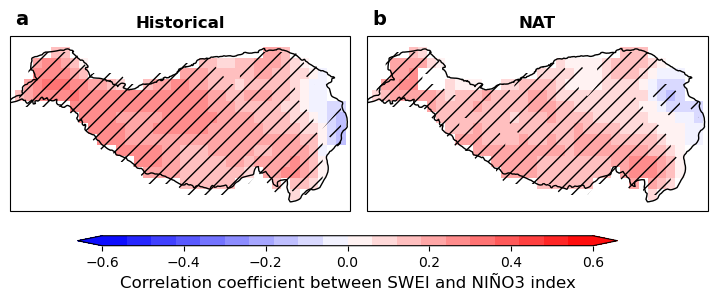

In [13]:
# plot a 1*2 subplot figure for ensemble mean of the correlation between SWEI and NINO3
import cmaps
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(wspace=0.05, hspace=0.3)

ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
cbar_ax1 = fig.add_axes([0.2, 0.25, 0.6, 0.02])
p1 = swei_NINO3_corr_ensmean_hist.plot(ax=ax1, vmax=0.6, vmin=-0.6, cmap=cmaps.GMT_polar, add_colorbar=False)
fig_cbar1 = fig.colorbar(p1, cax=cbar_ax1, orientation='horizontal', extend='both')
fig_cbar1.set_label('Correlation coefficient between SWEI and NIÑO3 index',fontdict={'fontsize': 12})
swei_NINO3_corr_sig_hist.plot.contourf(ax=ax1, hatches=[None,'//'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax1.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax1.set_title('Historical',fontdict={'fontsize': 12, 'fontweight': 'bold'})
# add TP shapefile
TP_shp.plot(ax=ax1, edgecolor='black', facecolor='none')
add_panel_label(ax1, 'a', x=0.015, y=1.15)

ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
p2 = swei_NINO3_corr_ensmean_NAT.plot(ax=ax2, vmax=0.6, vmin=-0.6, cmap=cmaps.GMT_polar, add_colorbar=False)
swei_NINO3_corr_sig_NAT.plot.contourf(ax=ax2, hatches=[None,'//'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax2.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax2.set_title('NAT',fontdict={'fontsize': 12, 'fontweight': 'bold'})
# add TP shapefile
TP_shp.plot(ax=ax2, edgecolor='black', facecolor='none')
add_panel_label(ax2, 'b', x=0.015, y=1.15)

plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/corr_SWEI_NINO3_ensmean.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/corr_SWEI_NINO3_ensmean.pdf', bbox_inches='tight')

# calculate the correlation between area-weighted mean SWEI and NINO3

In [11]:
# calculate the correlation between area-weighted mean SWEI and NINO3 for historical senario
for sn in hist_source:
    ds_swei_year_ts, ds_swei_month_ts = cal_CMIP6_area_weighted_SWEI(sn, 'hist')
    if sn == hist_source[0]:
        ds_swei_year_ts_all_hist = ds_swei_year_ts.to_dataframe()['swei']
        ds_swei_year_ts_all_hist.name = sn
    else:
        to_append = ds_swei_year_ts.to_dataframe()['swei']
        to_append.name = sn
        ds_swei_year_ts_all_hist = pd.concat([ds_swei_year_ts_all_hist, to_append], axis=1)

tos_nino3_index_HIST.index = pd.to_datetime(tos_nino3_index_HIST.index)
corr_SWEI_NINO3_all_hist = []
pvalue_SWEI_NINO3_all_hist = []
for sn in hist_source:
    NINO3 = tos_nino3_index_HIST[sn]
    NINO3 = NINO3['1979':'2022']
    NINO3_QS = NINO3.resample('QS-DEC').mean()
    NINO3_QS_DJF = NINO3_QS[NINO3_QS.index.month == 12]
    NINO3_QS_DJF = NINO3_QS_DJF[1:]
    corr_SWEI_NINO3_all_hist.append(corr_cal(ds_swei_year_ts_all_hist[sn], NINO3_QS_DJF))
    pvalue_SWEI_NINO3_all_hist.append(corr_p_cal(ds_swei_year_ts_all_hist[sn], NINO3_QS_DJF))

# combine corr_SWEI_NINO3_all and pvalue_SWEI_NINO3_all into one dataframe
corr_SWEI_NINO3_all_hist = pd.DataFrame({'corr':corr_SWEI_NINO3_all_hist, 'pvalue':pvalue_SWEI_NINO3_all_hist}, index=hist_source)

In [ ]:
corr_SWEI_NINO3_all_hist

,corr,pvalue
ACCESS-CM2,0.006372,9.672564e-01
ACCESS-ESM1-5,0.110518,4.751156e-01
BCC-CSM2-MR,-0.181486,2.383962e-01
CESM2,0.684763,2.953395e-07
CESM2-WACCM,0.556677,8.701980e-05
CIESM,0.467279,1.384234e-03
CNRM-CM6-1,0.331543,2.791382e-02
CanESM5,0.179347,2.440671e-01
CanESM5-1,0.249652,1.021902e-01
E3SM-1-0,0.569058,5.560542e-05


In [ ]:
corr_SWEI_NINO3_all_hist.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/corr_SWEI_NINO3_all_hist.csv')

In [31]:
# calculate the correlation between area-weighted mean SWEI and NINO3 for NAT senario
for sn in NAT_source:
    ds_swei_year_ts, ds_swei_month_ts = cal_CMIP6_area_weighted_SWEI(sn, 'NAT')
    if sn == NAT_source[0]:
        ds_swei_year_ts.name = sn
        ds_swei_year_ts_all_NAT = ds_swei_year_ts.to_dataframe()[sn]
    else:
        ds_swei_year_ts.name = sn
        to_append = ds_swei_year_ts.to_dataframe()[sn]
        ds_swei_year_ts_all_NAT = pd.concat([ds_swei_year_ts_all_NAT, to_append], axis=1)

# sort ds_swei_year_ts_all_NAT by index
ds_swei_year_ts_all_NAT = ds_swei_year_ts_all_NAT.sort_index()

tos_nino3_index_NAT.index = pd.to_datetime(tos_nino3_index_NAT.index)
corr_SWEI_NINO3_all_NAT = []
pvalue_SWEI_NINO3_all_NAT = []
for sn in NAT_source:
    NINO3 = tos_nino3_index_NAT[sn]
    swei_NAT_sn = ds_swei_year_ts_all_NAT[sn]
    swei_NAT_sn = swei_NAT_sn.dropna()
    NINO3 = NINO3[str(swei_NAT_sn.index[0]):str(swei_NAT_sn.index[-1])]
    NINO3_QS = NINO3.resample('QS-DEC').mean()
    NINO3_QS_DJF = NINO3_QS[NINO3_QS.index.month == 12]
    NINO3_QS_DJF = NINO3_QS_DJF[1:]
    corr_SWEI_NINO3_all_NAT.append(corr_cal(swei_NAT_sn, NINO3_QS_DJF))
    pvalue_SWEI_NINO3_all_NAT.append(corr_p_cal(swei_NAT_sn, NINO3_QS_DJF))

# combine corr_SWEI_NINO3_all and pvalue_SWEI_NINO3_all into one dataframe
corr_SWEI_NINO3_all_NAT = pd.DataFrame({'corr':corr_SWEI_NINO3_all_NAT, 'pvalue':pvalue_SWEI_NINO3_all_NAT}, index=NAT_source)

In [ ]:
corr_SWEI_NINO3_all_NAT

,corr,pvalue
ACCESS-CM2,0.177483,0.249085
ACCESS-ESM1-5,0.019228,0.901409
BCC-CSM2-MR,0.052402,0.735499
CESM2,0.496881,0.000602
CNRM-CM6-1,0.337379,0.025117
CanESM5,0.035091,0.821093
E3SM-2-0,0.316144,0.036560
GFDL-CM4,0.326816,0.030366
GFDL-ESM4,0.462441,0.001575
GISS-E2-1-G,0.595014,0.000020


In [ ]:
corr_SWEI_NINO3_all_NAT.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/corr_SWEI_NINO3_all_NAT.csv')

In [33]:
ds_swei_year_ts_all_hist.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/SWEI_year_ts_all_hist.csv')
ds_swei_year_ts_all_NAT.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/SWEI_year_ts_all_NAT.csv')

# plot the spatial distributin of trends in SWEI

In [ ]:
# calculate the trends in area-weighted mean SWEI for historical senario
swei_trend_hist = ds_swei_year_ts_all_hist.apply(_compute_slope)
swei_trend_pval_hist = ds_swei_year_ts_all_hist.apply(_compute_trend_pval)
swei_trend_hist = pd.DataFrame({'trend':swei_trend_hist, 'pvalue':swei_trend_pval_hist}, index=hist_source)

# calculate the trends in area-weighted mean SWEI for NAT senario
swei_trend_NAT = ds_swei_year_ts_all_NAT.apply(_compute_slope)
swei_trend_pval_NAT = ds_swei_year_ts_all_NAT.apply(_compute_trend_pval)
swei_trend_NAT = pd.DataFrame({'trend':swei_trend_NAT, 'pvalue':swei_trend_pval_NAT}, index=NAT_source)

In [ ]:
swei_trend_hist.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/SWEI_trend_hist.csv')
swei_trend_hist

,trend,pvalue
ACCESS-CM2,-0.007118,1.181298e-01
ACCESS-ESM1-5,-0.010987,8.842436e-02
BCC-CSM2-MR,-0.014258,2.703801e-03
CESM2,-0.017438,3.013757e-02
CESM2-WACCM,-0.013125,1.015101e-01
CIESM,0.008606,5.657504e-02
CNRM-CM6-1,-0.005791,3.369921e-01
CanESM5,-0.031415,2.418418e-08
CanESM5-1,-0.024335,4.259389e-06
E3SM-1-0,0.000365,9.531428e-01


In [ ]:
swei_trend_NAT.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/SWEI_trend_NAT.csv')
swei_trend_NAT

,trend,pvalue
ACCESS-CM2,0.007580,0.050685
ACCESS-ESM1-5,-0.007346,0.135350
BCC-CSM2-MR,0.003296,0.519999
CESM2,-0.002282,0.713101
CNRM-CM6-1,-0.004547,0.290542
CanESM5,0.006422,0.081620
E3SM-2-0,-0.004363,0.465530
GFDL-CM4,-0.000043,0.992666
GFDL-ESM4,-0.004340,0.362637
GISS-E2-1-G,0.003369,0.421775


In [ ]:
# calculate SWEI trend for each grid point
def cal_SWEI_trend(sn, senario):
    if senario == 'hist':
        ds_swei = get_CMIP6_swei(sn, senario)
    elif senario == 'NAT':
        ds_swei = NAT_swei_cal_2(sn)
    ds_swei_year = ds_swei.sel(month=3)
    # calculate the trend of SWEI
    swei_trend = trend_cal(ds_swei_year)
    swei_trend_pval = trend_cal_pval(ds_swei_year)
    return swei_trend, swei_trend_pval

In [ ]:
# plot a figure
def plot_SWEI_trend(senario):
    if senario == 'hist':
        fig = plt.figure(figsize=(11, 16))
        for i in range(32):
            ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree())
            swei_trend, swei_trend_pval = cal_SWEI_trend(hist_source[i], senario)
            swei_trend = swei_trend['swei']
            swei_trend_pval = swei_trend_pval['swei']
            swei_trend.plot(ax=ax, vmax=0.05, vmin=-0.05, cmap='RdBu_r', add_colorbar=False)

            # add hatches to the grid cells with p-value < 0.05
            swei_trend_pval.where(swei_trend_pval<0.05).plot.contourf(ax=ax, levels=[0, 0.05], hatches=['///'], alpha=0, add_colorbar=False)
            ax.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
            ax.set_title(hist_source[i],fontdict={'fontsize': 11})
            add_panel_label(ax, number_labels[i], x=0.015, y=1.25)
            # add TP shapefile
            TP_shp.plot(ax=ax, edgecolor='black', facecolor='none')
            # add colorbar in the bottom
            if i == 31:
                fig.subplots_adjust(bottom=0.2)
                cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.0125])
                fig.colorbar(ax.collections[0], cax=cbar_ax, orientation='horizontal', extend='both')
                cbar_ax.set_title('Trend of SWEI (unit yr$^{-1}$)',fontdict={'fontsize': 12})
    elif senario == 'NAT':
        fig = plt.figure(figsize=(8, 10))
        for i in range(15):
            ax = fig.add_subplot(5, 3, i+1, projection=ccrs.PlateCarree())
            swei_trend, swei_trend_pval = cal_SWEI_trend(NAT_source[i], senario)
            swei_trend = swei_trend
            swei_trend_pval = swei_trend_pval
            swei_trend.plot(ax=ax, vmax=0.05, vmin=-0.05, cmap='RdBu_r', add_colorbar=False)

            # add hatches to the grid cells with p-value < 0.05
            swei_trend_pval.where(swei_trend_pval<0.05).plot.contourf(ax=ax, levels=[0, 0.05], hatches=['///'], alpha=0, add_colorbar=False)
            ax.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
            ax.set_title(NAT_source[i],fontdict={'fontsize': 11})
            add_panel_label(ax, number_labels[i], x=0.015, y=1.25)
            # add TP shapefile
            TP_shp.plot(ax=ax, edgecolor='black', facecolor='none')
            # add colorbar in the bottom
            if i == 14:
                fig.subplots_adjust(bottom=0.2)
                cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.0125])
                fig.colorbar(ax.collections[0], cax=cbar_ax, orientation='horizontal', extend='both')
                cbar_ax.set_title('Trend of SWEI (unit yr$^{-1}$)',fontdict={'fontsize': 12})


In [ ]:
# save the trend of SWEI under historical senario to netcdf
for sn in hist_source:
    swei_trend, swei_trend_pval = cal_SWEI_trend(sn, 'hist')
    swei_trend.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/SWEI_trend_' + sn + '.nc')
    swei_trend_pval.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/SWEI_trend_pval_' + sn + '.nc')

In [ ]:
# save the trend of SWEI under NAT senario to netcdf
for sn in NAT_source:
    swei_trend, swei_trend_pval = cal_SWEI_trend(sn, 'NAT')
    swei_trend.name = 'swei'
    swei_trend_pval.name = 'swei'
    swei_trend.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/SWEI_trend_' + sn + '.nc')
    swei_trend_pval.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/SWEI_trend_pval_' + sn + '.nc')

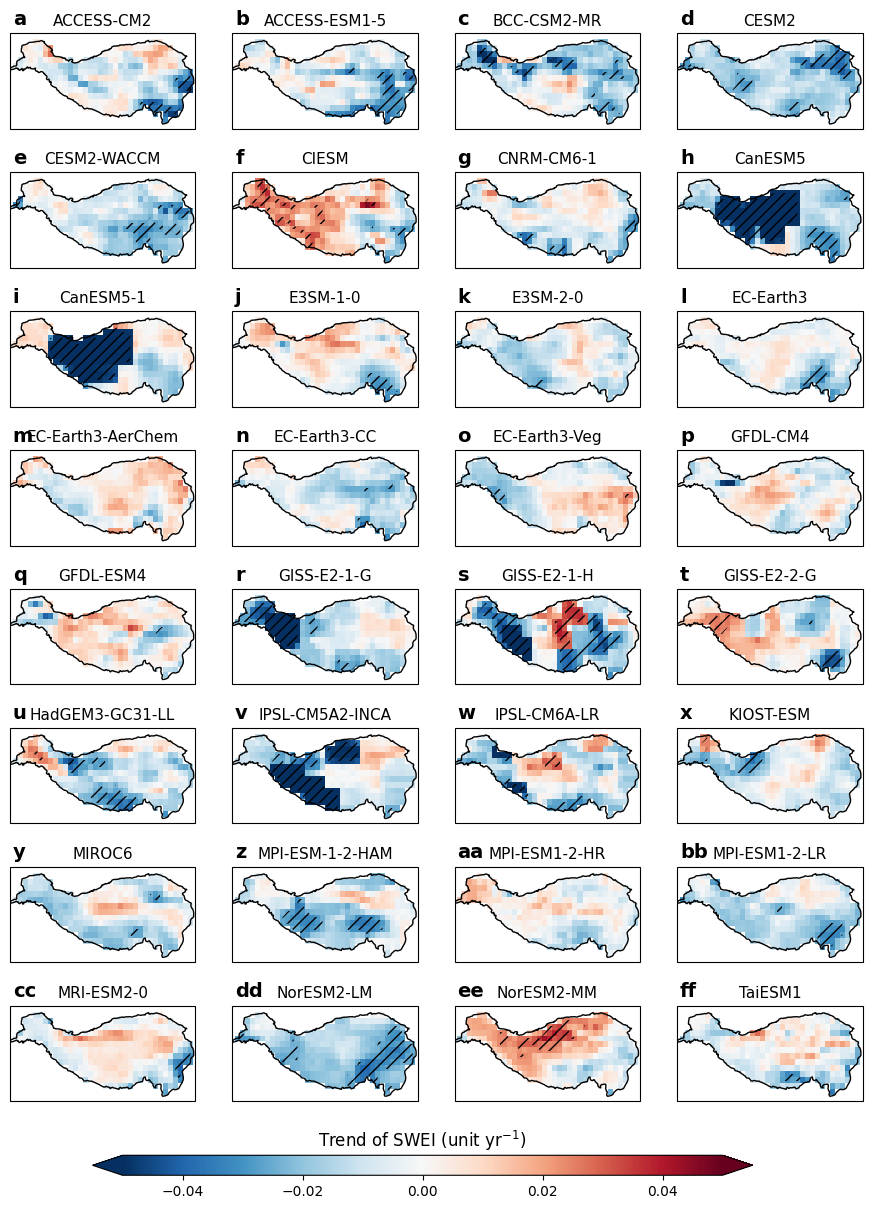

In [ ]:
plot_SWEI_trend('hist')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/trend_SWEI_hist.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/trend_SWEI_hist.pdf', bbox_inches='tight')

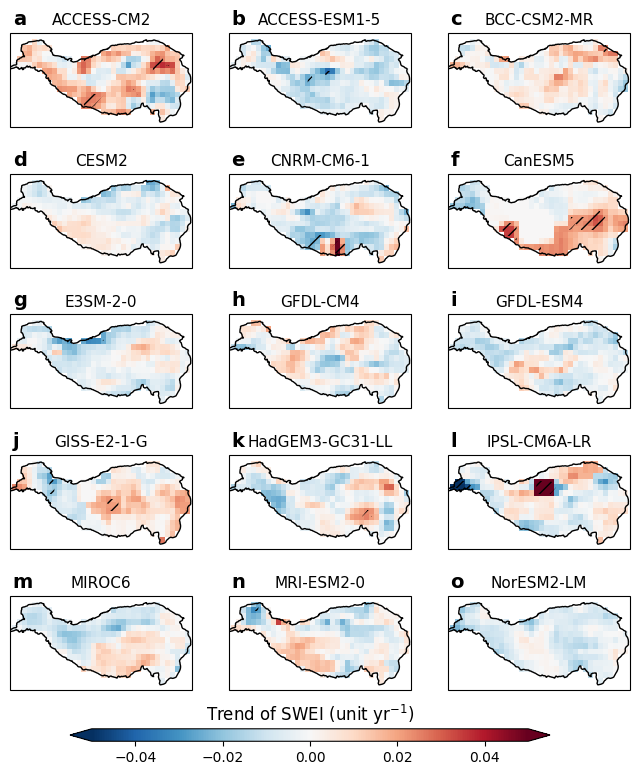

In [ ]:
plot_SWEI_trend('NAT')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/trend_SWEI_NAT.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/trend_SWEI_NAT.pdf', bbox_inches='tight')

In [ ]:
# plot ensemble mean of SWEI trend
def cal_SWEI_trend_ensmean(senario):
    if senario == 'hist':
        sn_list = hist_source
    elif senario == 'NAT':
        sn_list = NAT_source
    else:
        print('Please input the correct senario name: hist or NAT')
    
    swei_trend_ensmean = 0
    swei_trend_pos_enssum = 0
    swei_trend_neg_enssum = 0

    for sn in sn_list:
        swei_trend, _ = cal_SWEI_trend(sn, senario)
        try:
            swei_trend = swei_trend['swei']
        except:
            pass
        swei_trend_pos = swei_trend > 0
        swei_trend_neg = swei_trend < 0
        if sn == sn_list[0]:
            swei_trend_ensmean = swei_trend
            swei_trend_pos_enssum = swei_trend_pos * 1
            swei_trend_neg_enssum = swei_trend_neg * 1
        else:
            swei_trend_ensmean = swei_trend_ensmean + swei_trend
            swei_trend_pos_enssum = swei_trend_pos_enssum + swei_trend_pos * 1
            swei_trend_neg_enssum = swei_trend_neg_enssum + swei_trend_neg * 1
    swei_trend_ensmean = swei_trend_ensmean/len(sn_list)
    swei_trend_sig = ((swei_trend_neg_enssum > len(sn_list) * 2 / 3) & (swei_trend_ensmean < 0)) | ((swei_trend_pos_enssum > len(sn_list) * 2 / 3) & (swei_trend_ensmean > 0))
    return swei_trend_ensmean, swei_trend_sig


<GeoAxesSubplot:title={'center':'SWEI trend'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

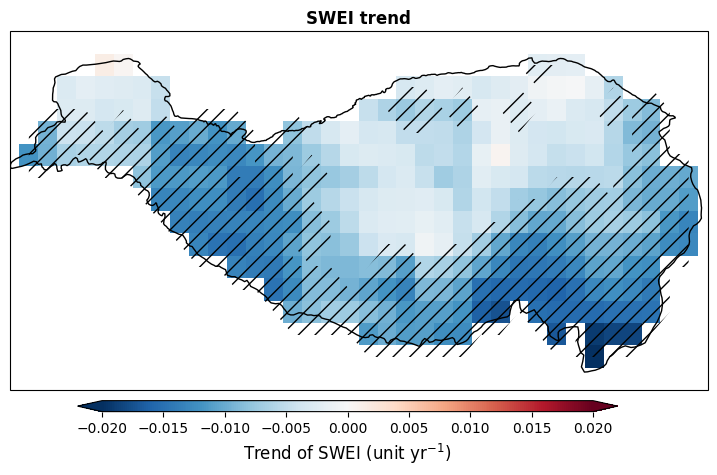

In [ ]:
# plot ensemble mean of SWEI trend for historical senario
swei_trend_ensmean_hist, swei_trend_sig_hist = cal_SWEI_trend_ensmean('hist')

fig = plt.figure(figsize=(9, 5.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.2, 0.13, 0.6, 0.02])
p = swei_trend_ensmean_hist.plot(ax=ax, vmax=0.02, vmin=-0.02, cmap='RdBu_r', add_colorbar=False)
fig_cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal', extend='both')
fig_cbar.set_label('Trend of SWEI (unit yr$^{-1}$)',fontdict={'fontsize': 12})

swei_trend_sig_hist.plot.contourf(ax=ax, hatches=[None,'//'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax.set_title('SWEI trend',fontdict={'fontsize': 12, 'fontweight': 'bold'})
# add TP shapefile
TP_shp.plot(ax=ax, edgecolor='black', facecolor='none')

In [ ]:
# save swei_trend_ensmean_hist, swei_trend_sig_hist to netcdf
swei_trend_ensmean_hist.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/swei_trend_ensmean_hist.nc')
swei_trend_sig_hist.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/swei_trend_ensmean_sig_hist.nc')

<GeoAxesSubplot:title={'center':'SWEI trend'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

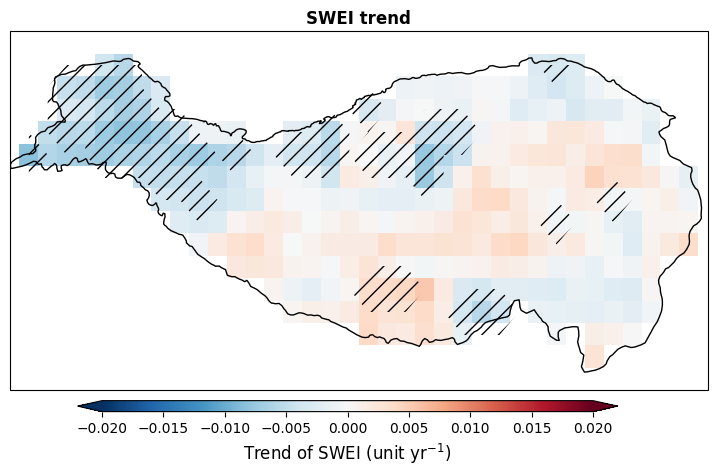

In [ ]:
# plot ensemble mean of SWEI trend for NAT senario
swei_trend_ensmean_NAT, swei_trend_sig_NAT = cal_SWEI_trend_ensmean('NAT')

fig = plt.figure(figsize=(9, 5.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.2, 0.13, 0.6, 0.02])
p = swei_trend_ensmean_NAT.plot(ax=ax, vmax=0.02, vmin=-0.02, cmap='RdBu_r', add_colorbar=False)
fig_cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal', extend='both')
fig_cbar.set_label('Trend of SWEI (unit yr$^{-1}$)',fontdict={'fontsize': 12})

swei_trend_sig_NAT.plot.contourf(ax=ax, hatches=[None,'//'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax.set_title('SWEI trend',fontdict={'fontsize': 12, 'fontweight': 'bold'})
# add TP shapefile
TP_shp.plot(ax=ax, edgecolor='black', facecolor='none')

In [ ]:
# save swei_trend_ensmean_NAT, swei_trend_sig_NAT to netcdf
swei_trend_ensmean_NAT.name = 'swei'
swei_trend_sig_NAT.name = 'swei'
swei_trend_ensmean_NAT.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/swei_trend_ensmean_NAT.nc')
swei_trend_sig_NAT.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/swei_trend_ensmean_sig_NAT.nc')

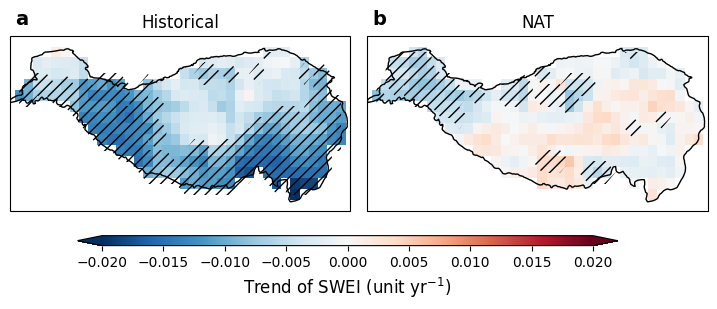

In [ ]:
# plot a 1*2 subplot figure of ensemble mean of SWEI trend for NAT historical senarios
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(wspace=0.05, hspace=0.3)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
cbar_ax1 = fig.add_axes([0.2, 0.25, 0.6, 0.02])
p1 = swei_trend_ensmean_hist.plot(ax=ax1, vmax=0.02, vmin=-0.02, cmap='RdBu_r', add_colorbar=False)
fig_cbar1 = fig.colorbar(p1, cax=cbar_ax1, orientation='horizontal', extend='both')
fig_cbar1.set_label('Trend of SWEI (unit yr$^{-1}$)',fontdict={'fontsize': 12})

swei_trend_sig_hist.plot.contourf(ax=ax1, hatches=[None,'///'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax1.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax1.set_title('Historical',fontdict={'fontsize': 12, 'fontweight': 'normal'})
TP_shp.plot(ax=ax1, edgecolor='black', facecolor='none')
add_panel_label(ax1, 'a', x=0.015, y=1.15)

ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
p2 = swei_trend_ensmean_NAT.plot(ax=ax2, vmax=0.02, vmin=-0.02, cmap='RdBu_r', add_colorbar=False)

swei_trend_sig_NAT.plot.contourf(ax=ax2, hatches=[None,'///'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax2.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax2.set_title('NAT',fontdict={'fontsize': 12, 'fontweight': 'normal'})
TP_shp.plot(ax=ax2, edgecolor='black', facecolor='none')
add_panel_label(ax2, 'b', x=0.015, y=1.15)

plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/trend_SWEI_ensemble.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/trend_SWEI_ensemble.pdf', bbox_inches='tight')


<AxesSubplot:xlabel='year'>

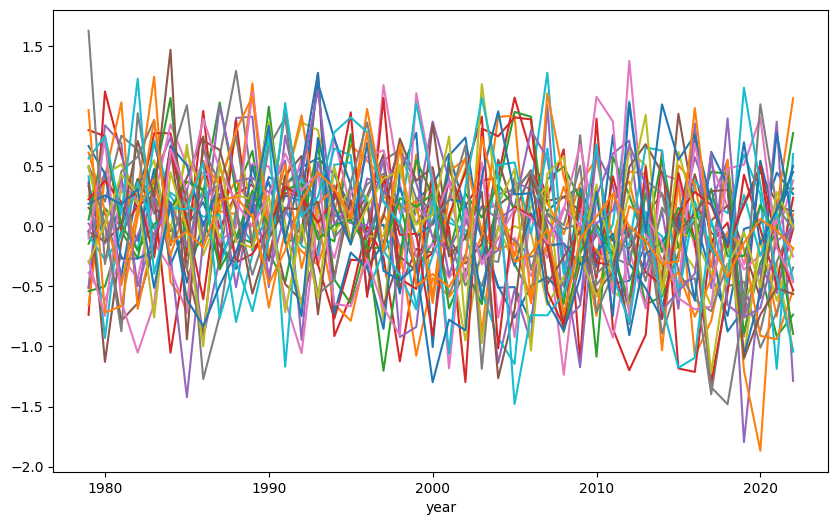

In [ ]:
ds_swei_year_ts_all_hist.plot(figsize=(10, 6), legend=False)

Text(0.5, 1.0, 'Mean and standard deviation of SWEI')

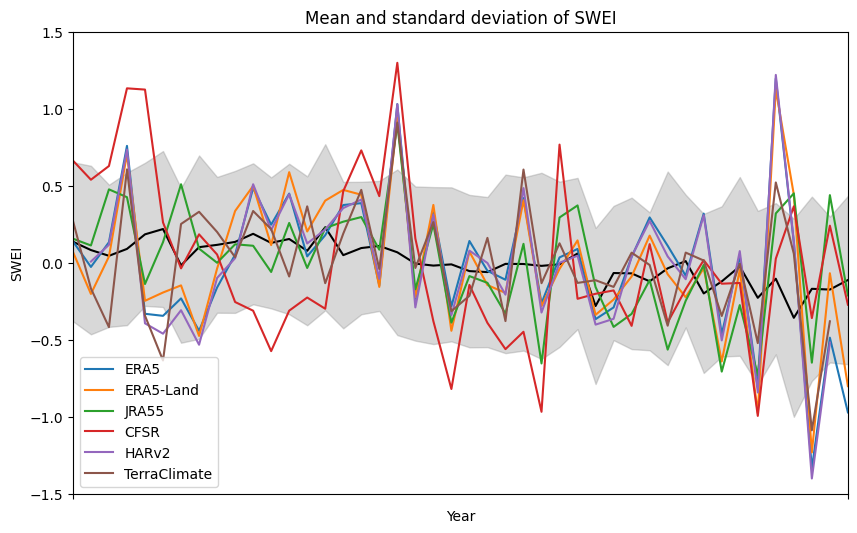

In [ ]:
ds_swei_year_ts_all_hist.index = pd.to_datetime(ds_swei_year_ts_all_hist.index)
ds_swei_year_ts_all_hist_std = ds_swei_year_ts_all_hist.std(axis=1)
ds_swei_year_ts_all_hist_mean = ds_swei_year_ts_all_hist.mean(axis=1)
obs_swei_year_ts = pd.read_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/SWEI_year_ts.csv', index_col=0)
obs_swei_year_ts.index = ds_swei_year_ts_all_hist.index
# plot mean and std of SWEI, mean as the solid line, std as the shaded area
fig, ax = plt.subplots(figsize=(10, 6))
ds_swei_year_ts_all_hist_mean.plot(ax=ax, color='black')
obs_swei_year_ts.plot(ax=ax)
ax.fill_between(ds_swei_year_ts_all_hist_mean.index, ds_swei_year_ts_all_hist_mean - ds_swei_year_ts_all_hist_std, ds_swei_year_ts_all_hist_mean + ds_swei_year_ts_all_hist_std, color='gray', alpha=0.3)
ax.set_ylim(-1.5, 1.5)
ax.set_ylabel('SWEI')
ax.set_xlabel('Year')
ax.set_title('Mean and standard deviation of SWEI')